# Connect to Kaggle

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

from keras.layers import Input, Flatten, Dense, Activation, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.utils.vis_utils import plot_model

from keras.datasets import cifar10

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rayraylu","key":"ebfb91ca043b4429e1f986bf957d7063"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.32G/1.33G [00:08<00:00, 183MB/s]
100% 1.33G/1.33G [00:08<00:00, 164MB/s]


In [6]:
! unzip celeba-dataset.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_al

#1.EDA

In [7]:
import matplotlib.pyplot as plt

In [8]:
attr = pd.read_csv('list_attr_celeba.csv')
attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [9]:
attr = attr.replace(-1,0)
attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


### 觀察哪個attribute有無的數值差距較小

In [10]:
da_attr = attr.describe()
da_attr

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,0.111136,0.266981,0.512505,0.204572,0.022443,0.151575,0.240796,0.234532,0.239251,0.147992,0.050899,0.205194,0.142168,0.057567,0.046688,0.065119,0.062764,0.041950,0.386922,0.455032,0.416754,0.483428,0.041545,0.115149,0.834940,0.284143,0.042947,0.277445,0.079778,0.065721,0.056511,0.48208,0.208402,0.319567,0.188925,0.048460,0.472436,0.122967,0.072715,0.773617
std,0.314301,0.442383,0.499845,0.403389,0.148121,0.358610,0.427568,0.423707,0.426627,0.355093,0.219791,0.403844,0.349223,0.232923,0.210971,0.246736,0.242539,0.200475,0.487047,0.497975,0.493023,0.499727,0.199548,0.319202,0.371236,0.451006,0.202738,0.447739,0.270950,0.247794,0.230906,0.49968,0.406167,0.466310,0.391450,0.214737,0.499241,0.328400,0.259669,0.418491
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
for i in range(40):
    columnname = da_attr.columns[i]
    if da_attr.iloc[1,i] > 0.35 and da_attr.iloc[1,i] < 0.65:   #將範圍訂在0.35及0.65之間
        print(columnname)

Attractive
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Smiling
Wearing_Lipstick


#2.Preparing Data

### Show Image

In [12]:
import numpy as np 
import pandas as pd

import os
os.mkdir("generated_images")
os.mkdir("saved_models")

from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm # 進度條

In [13]:
import cv2
img = cv2.imread('img_align_celeba/img_align_celeba/000001.jpg')

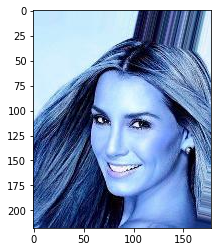

In [14]:
plt.imshow(img)
#plt.axis('off')
plt.show()

### Split Data into Training, Validation and Testing Data

In [15]:
partition_df = pd.read_csv("/content/list_eval_partition.csv")
partition_df.sample(10)

,image_id,partition
192623,192624.jpg,2
50057,050058.jpg,0
37681,037682.jpg,0
148435,148436.jpg,0
153626,153627.jpg,0
188950,188951.jpg,2
144284,144285.jpg,0
45781,045782.jpg,0
117159,117160.jpg,0
131633,131634.jpg,0


In [16]:
partition_df['partition'].value_counts()

0    162770
2     19962
1     19867
Name: partition, dtype: int64

In [17]:
part1_df = partition_df.join(attr['Smiling'])
part1_df

,image_id,partition,Smiling
0,000001.jpg,0,1
1,000002.jpg,0,1
2,000003.jpg,0,0
3,000004.jpg,0,0
4,000005.jpg,0,0
...,...,...,...
202594,202595.jpg,2,0
202595,202596.jpg,2,1
202596,202597.jpg,2,1
202597,202598.jpg,2,1


#3.Build CNN Model

### Data Augmentation

In [18]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

In [19]:
from keras.preprocessing.image import ImageDataGenerator
import cv2

In [20]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,)+x.shape)
    return x

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


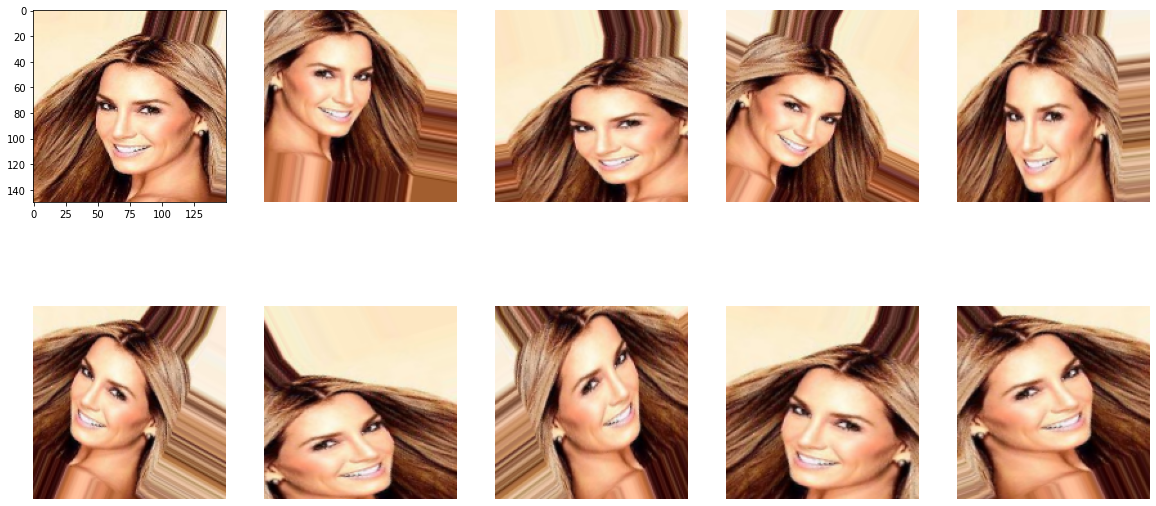

In [21]:
img_gen = ImageDataGenerator(    
    rotation_range=30, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', 
    dtype=np.float32)

batch_size = 4
width = 150
height = 150

##讀入照片
img = cv2.imread("img_align_celeba/img_align_celeba/000001.jpg")  
img = cv2.resize(img, (150,150)) #改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #cv2讀進來是BGR，轉成RGB
img_origin = img.copy()
img = np.array(img, dtype=np.float32)

img_combine = np.array([img,img,img,img],dtype=np.float32) #輸入generator要是四維

batch_gen = img_gen.flow(img_combine, batch_size=4)
assert next(batch_gen).shape==(batch_size, width, height, 3)

plt.figure(figsize=(20,10))
i = 1
for batch in batch_gen:
    plt.subplot(2, 5, 1)
    plt.imshow(img_origin)
    plt.subplot(2, 5, i+1)
    plt.imshow(batch[0, :, :, :].astype(np.uint8))
    plt.imshow(batch[1, :, :, :].astype(np.uint8))
    plt.imshow(batch[2, :, :, :].astype(np.uint8))
    plt.imshow(batch[3, :, :, :].astype(np.uint8))
    plt.axis('off')
    i += 1
    if i > 9:
        break  #避免無限迴圈

In [ ]:
#Don't Run

partition = 0
df_ = part1_df[(part1_df['partition'] == partition) & (part1_df['Smiling'] == 0)].sample(int(6000/2))            #選擇attr為smiling且num_samples=6000
df_ = pd.concat([df_, part1_df[(part1_df['partition'] == partition) & (part1_df['Smiling'] == 1)].sample(int(6000/2))])

# for Train and Validation
path = 'img_align_celeba/img_align_celeba/'
if partition != 2:
  for fname in df_.index:
    x_train = np.array(load_reshape_img(path + fname))
    x_train = x_train.reshape(x_train.shape[0], 218, 178, 3)
    y_train = np_utils.to_categorical(df_['Smiling'],2)
        
# for Test
else:
  x_train = []
  y_train = []

  for index, target in df_.iterrows():
    im = cv2.imread(path + index)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (img_width, img_height)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    x_train.append(im)
    y_train.append(target['Smiling'])

In [22]:
#Don't Run

partition = 0
df_ = part1_df[(part1_df['partition'] == partition) & (part1_df['Smiling'] == 0)].sample(int(6000/2))            #選擇attr為smiling且num_samples=6000
df_ = pd.concat([df_, part1_df[(part1_df['partition'] == partition) & (part1_df['Smiling'] == 1)].sample(int(6000/2))])

In [26]:
#Don't Run

path = 'img_align_celeba/img_align_celeba/'
for fname in df_.index:
    x_train = np.array(load_reshape_img(path + str(fname+1).zfill(6) + '.jpg'))
    x_train = x_train.reshape(x_train.shape[0], 218, 178, 3)
    y_train = np_utils.to_categorical(df_['Smiling'],2)

In [52]:
x = np.array(load_reshape_img('img_align_celeba/img_align_celeba/000001.jpg'))
x.shape[1]

218

In [28]:
def generate_df(partition, attr, num_samples):
    
    df_ = part1_df[(part1_df['partition'] == partition) 
                           & (part1_df[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_, part1_df[(part1_df['partition'] == partition) 
                                  & (part1_df[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    path = 'img_align_celeba/img_align_celeba/'
    if partition != 2:
      for fname in df_.index:
          x_ = np.array(load_reshape_img(path + str(fname+1).zfill(6) + '.jpg'))
          x_ = x_.reshape(x_.shape[0], 218, 178, 3)
          y_ = np_utils.to_categorical(df_[attr],2)
        
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(path + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (img_width, img_height)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

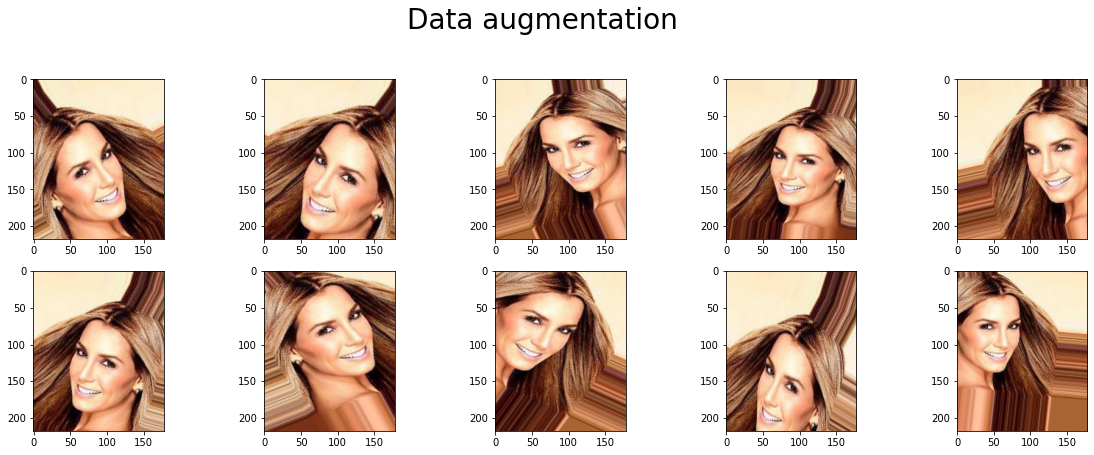

In [31]:
# generate image generator for data augmentation

datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# load one image and reshape

img = load_img('img_align_celeba/img_align_celeba/000001.jpg')
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded image

plt.figure(figsize=(20,10))
plt.suptitle("Data augmentation", fontsize=28)

i = 0

for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3,5,i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(218,178, 3))
    
    if i==9:
        break
    i = i+1
plt.show()

In [47]:
x_train, y_train = generate_df(0, "Smiling", 6000)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

train_datagen.fit(x_train)




In [55]:
df_

,image_id,partition,Smiling
12709,012710.jpg,0,0
70014,070015.jpg,0,0
1493,001494.jpg,0,0
98202,098203.jpg,0,0
76608,076609.jpg,0,0
...,...,...,...
117554,117555.jpg,0,1
19438,019439.jpg,0,1
138022,138023.jpg,0,1
104273,104274.jpg,0,1


In [40]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

ValueError: ignored

In [51]:
from os import listdir
from keras.preprocessing.image import load_img, img_to_array
from numpy import asarray

photos, targets = list(), list()
path = 'img_align_celeba/img_align_celeba/'
for filename in listdir(path)[1000:2000]:
    photo = load_img(path + filename, target_size=(128,128))
    photo = img_to_array(photo, dtype='uint8')
    photos.append(photo)
    targets.append(asarray(data[data.image_id == filename].iloc[:,1:]))
X = asarray(photos, dtype='uint8')
y = asarray(targets, dtype='uint8')
y = y.reshape(1000,40)

NameError: ignored